## Análisis de Agrupamientos (Clustering)
### Ejemplos de aplicación
### Notebook correspondiente al 
### Curso de postgrado/perfeccionamiento "Minería de Datos"
### Universidad Nacional de San Luis
### 25/10/18 - 14/12/18
#### lcagnina@unsl.edu.ar

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['image.cmap'] = "gray"
import warnings
warnings.filterwarnings("ignore")
#from sklearn.datasets import make_blobs
#from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
# Función dendrogram y clustering jerárquico (ward) de SciPy
#from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm

### El dataset de las caras (Labeled Faces in the Wild dataset)
Este dataset contiene imágenes de caras de celebridades que fueron tomadas de Internet. Incluye caras de políticos, cantantes, actores y atletas de los años 2000. Se utilizará la versión en escala de grises para reducir el tiempo de procesamiento de las mismas. La base de datos contiene datos de 5749 personas resultando en 13233 imágenes (cada una de aprox. 250x250 pixels).


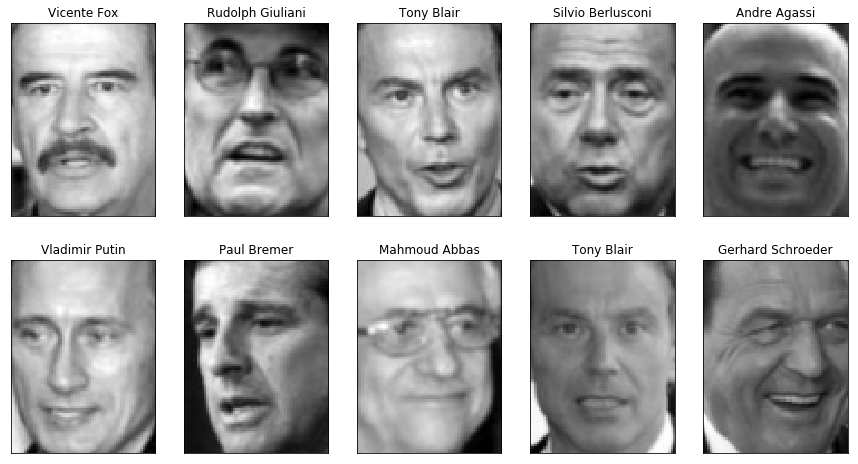

In [2]:
# importar la base de datos
from sklearn.datasets import fetch_lfw_people

#descargar algunas imágenes
#por defecto las guarda en C:\Users\Leticia\scikit_learn_data\lfw_home
people = fetch_lfw_people(min_faces_per_person=19, resize=0.7)

image_shape = people.images[0].shape

#ver algunas imágenes
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])



Veamos algunas estadísticas del dataset que hemos extraído: 3156 imágenes de 69 personas. Además podemos contar cuántas imágenes hay de cada persona. 

In [3]:
#estadísticas
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}\n".format(len(people.target_names)))

# contar
counts = np.bincount(people.target)
# imprimir
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()


people.images.shape: (3156, 87, 65)
Number of classes: 69

Abdullah Gul               19   Alejandro Toledo           39   Alvaro Uribe               35   
Amelie Mauresmo            21   Andre Agassi               36   Angelina Jolie             20   
Ariel Sharon               77   Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   
Bill Clinton               29   Carlos Menem               21   Carlos Moya                19   
Colin Powell              236   David Beckham              31   Donald Rumsfeld           121   
George Robertson           22   George W Bush             530   Gerhard Schroeder         109   
Gloria Macapagal Arroyo    44   Gray Davis                 26   Guillermo Coria            30   
Hamid Karzai               22   Hans Blix                  39   Hugo Chavez                71   
Igor Ivanov                20   Jack Straw                 28   Jacques Chirac             52   
Jean Chretien              55   Jennifer Aniston           21   Jenn

Como se puede observar, existen muchas imágenes para algunas personas (por ejemplo George W. Bush, Colin Powell, Tony Blair, etc.) lo cual introduce un importante sesgo de información que puede repercutir en las tareas de aprendizaje. 

Una práctica habitual es limitar la información que se considera. En la siguiente celda se puede observar cómo considerar sólo 50 imágenes de cada persona.

In [4]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

#calculo las nuevas estadísticas
print("Cantidad de caras: {}".format(people.images[mask].shape))
print("Correspondiente a personas: ", np.bincount(y_people).size)

# contar
counts=np.bincount(y_people)
# imprimir
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()



Cantidad de caras: (2196, 87, 65)
Correspondiente a personas:  69
Abdullah Gul               19   Alejandro Toledo           39   Alvaro Uribe               35   
Amelie Mauresmo            21   Andre Agassi               36   Angelina Jolie             20   
Ariel Sharon               50   Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   
Bill Clinton               29   Carlos Menem               21   Carlos Moya                19   
Colin Powell               50   David Beckham              31   Donald Rumsfeld            50   
George Robertson           22   George W Bush              50   Gerhard Schroeder          50   
Gloria Macapagal Arroyo    44   Gray Davis                 26   Guillermo Coria            30   
Hamid Karzai               22   Hans Blix                  39   Hugo Chavez                50   
Igor Ivanov                20   Jack Straw                 28   Jacques Chirac             50   
Jean Chretien              50   Jennifer Aniston           21

### Clustering de caras con k-means
Nos podría interesar encontrar estructuras interesantes en la base de datos de las caras. Veamos qué es posible observar utilizando el algoritmo k-means.

Una de las características de k-means es que el número de grupos a considerar es parámetro del algoritmo. En el caso de el dataset de caras se podría comenzar con un número de grupos bajo e ir aumentándolo a medida dependiendo los resultados que se vayan obteniendo.

In [5]:
# construcción del modelo de clustering
km = KMeans(n_clusters=2, random_state=0)
labels_km = km.fit_predict(X_people)
print("Tamaño de los grupos obtenidos: {}".format(np.bincount(labels_km)))

Tamaño de los grupos obtenidos: [ 928 1268]


Al parecer k-means ha organizado las 2196 imágenes en 2 grupos de cardinalidad bastante parecida. Ahora sería útil visualizar los centroides de cada grupo. 

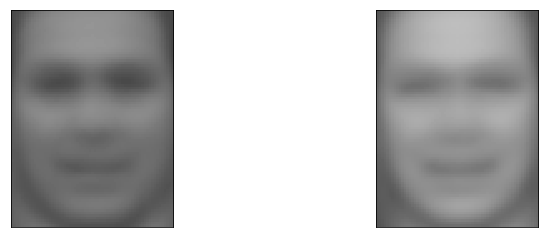

In [6]:
fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(center.reshape(image_shape), vmin=0, vmax=1)

Mucho no se puede inferir del estudio anterior. Repitamos el ejercicio con un número mayor de clusters: 40.

In [7]:
# construcción del modelo de clustering
km60 = KMeans(n_clusters=40, random_state=1)
labels_km60 = km60.fit_predict(X_people)
print("Tamaño de los grupos obtenidos: {}".format(np.bincount(labels_km60)))

Tamaño de los grupos obtenidos: [  8  64  64  61  32  68  61  46  72  48  89  49  89  63  54  43  88  44
  88  59  55 100  56  59  54  80  57  35  31   9  49  43  51  39  27  63
  38  56  49  55]


Visualicemos los 40 centroides.

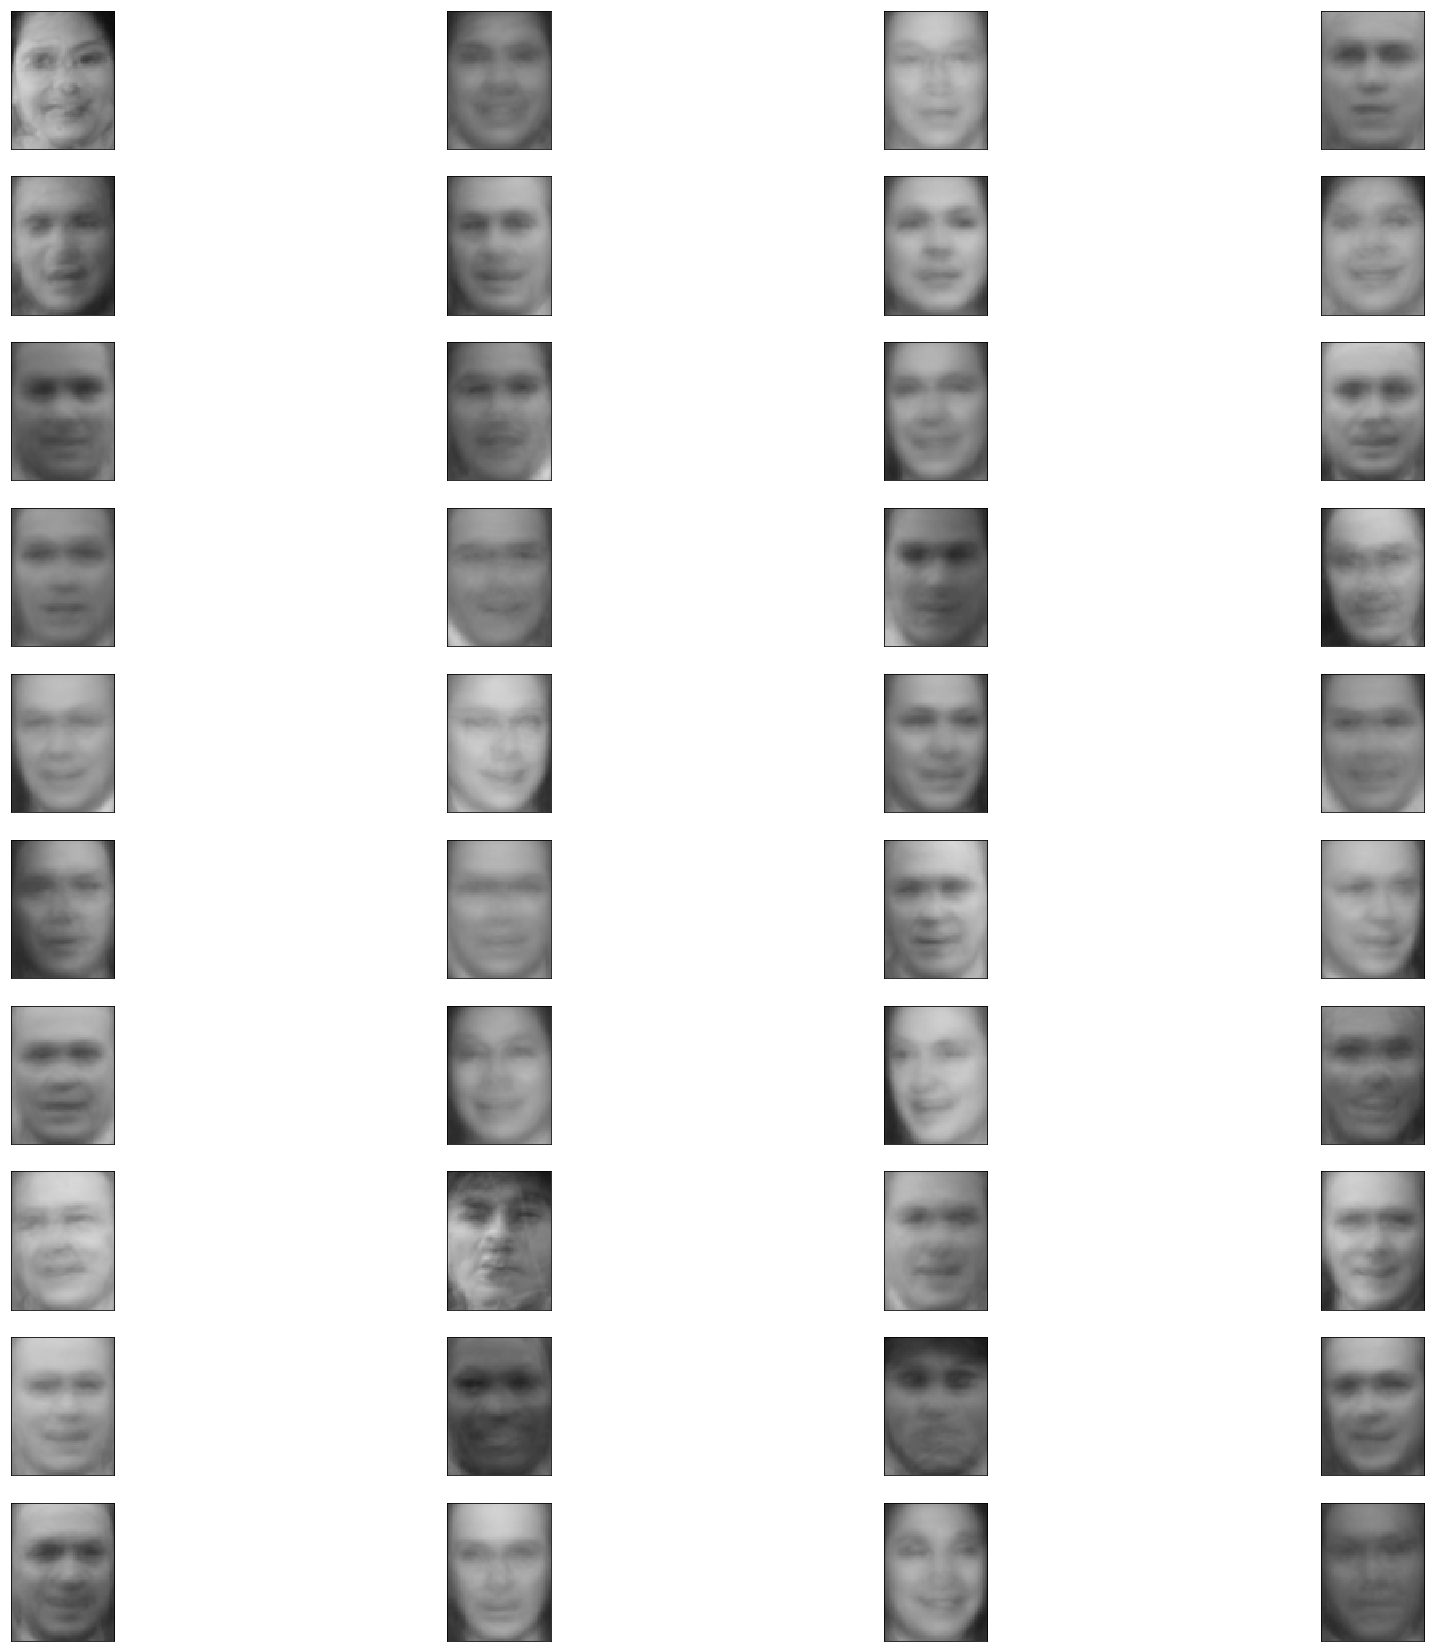

In [8]:
fig, axes = plt.subplots(10, 4, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(30, 30))
for center, ax in zip(km60.cluster_centers_, axes.ravel()):
    ax.imshow(center.reshape(image_shape), vmin=0, vmax=1)



Visualicemos algunos grupos (10 de ellos) para observar el resultado.

Text(0, -40, 'Lejos del centroide')

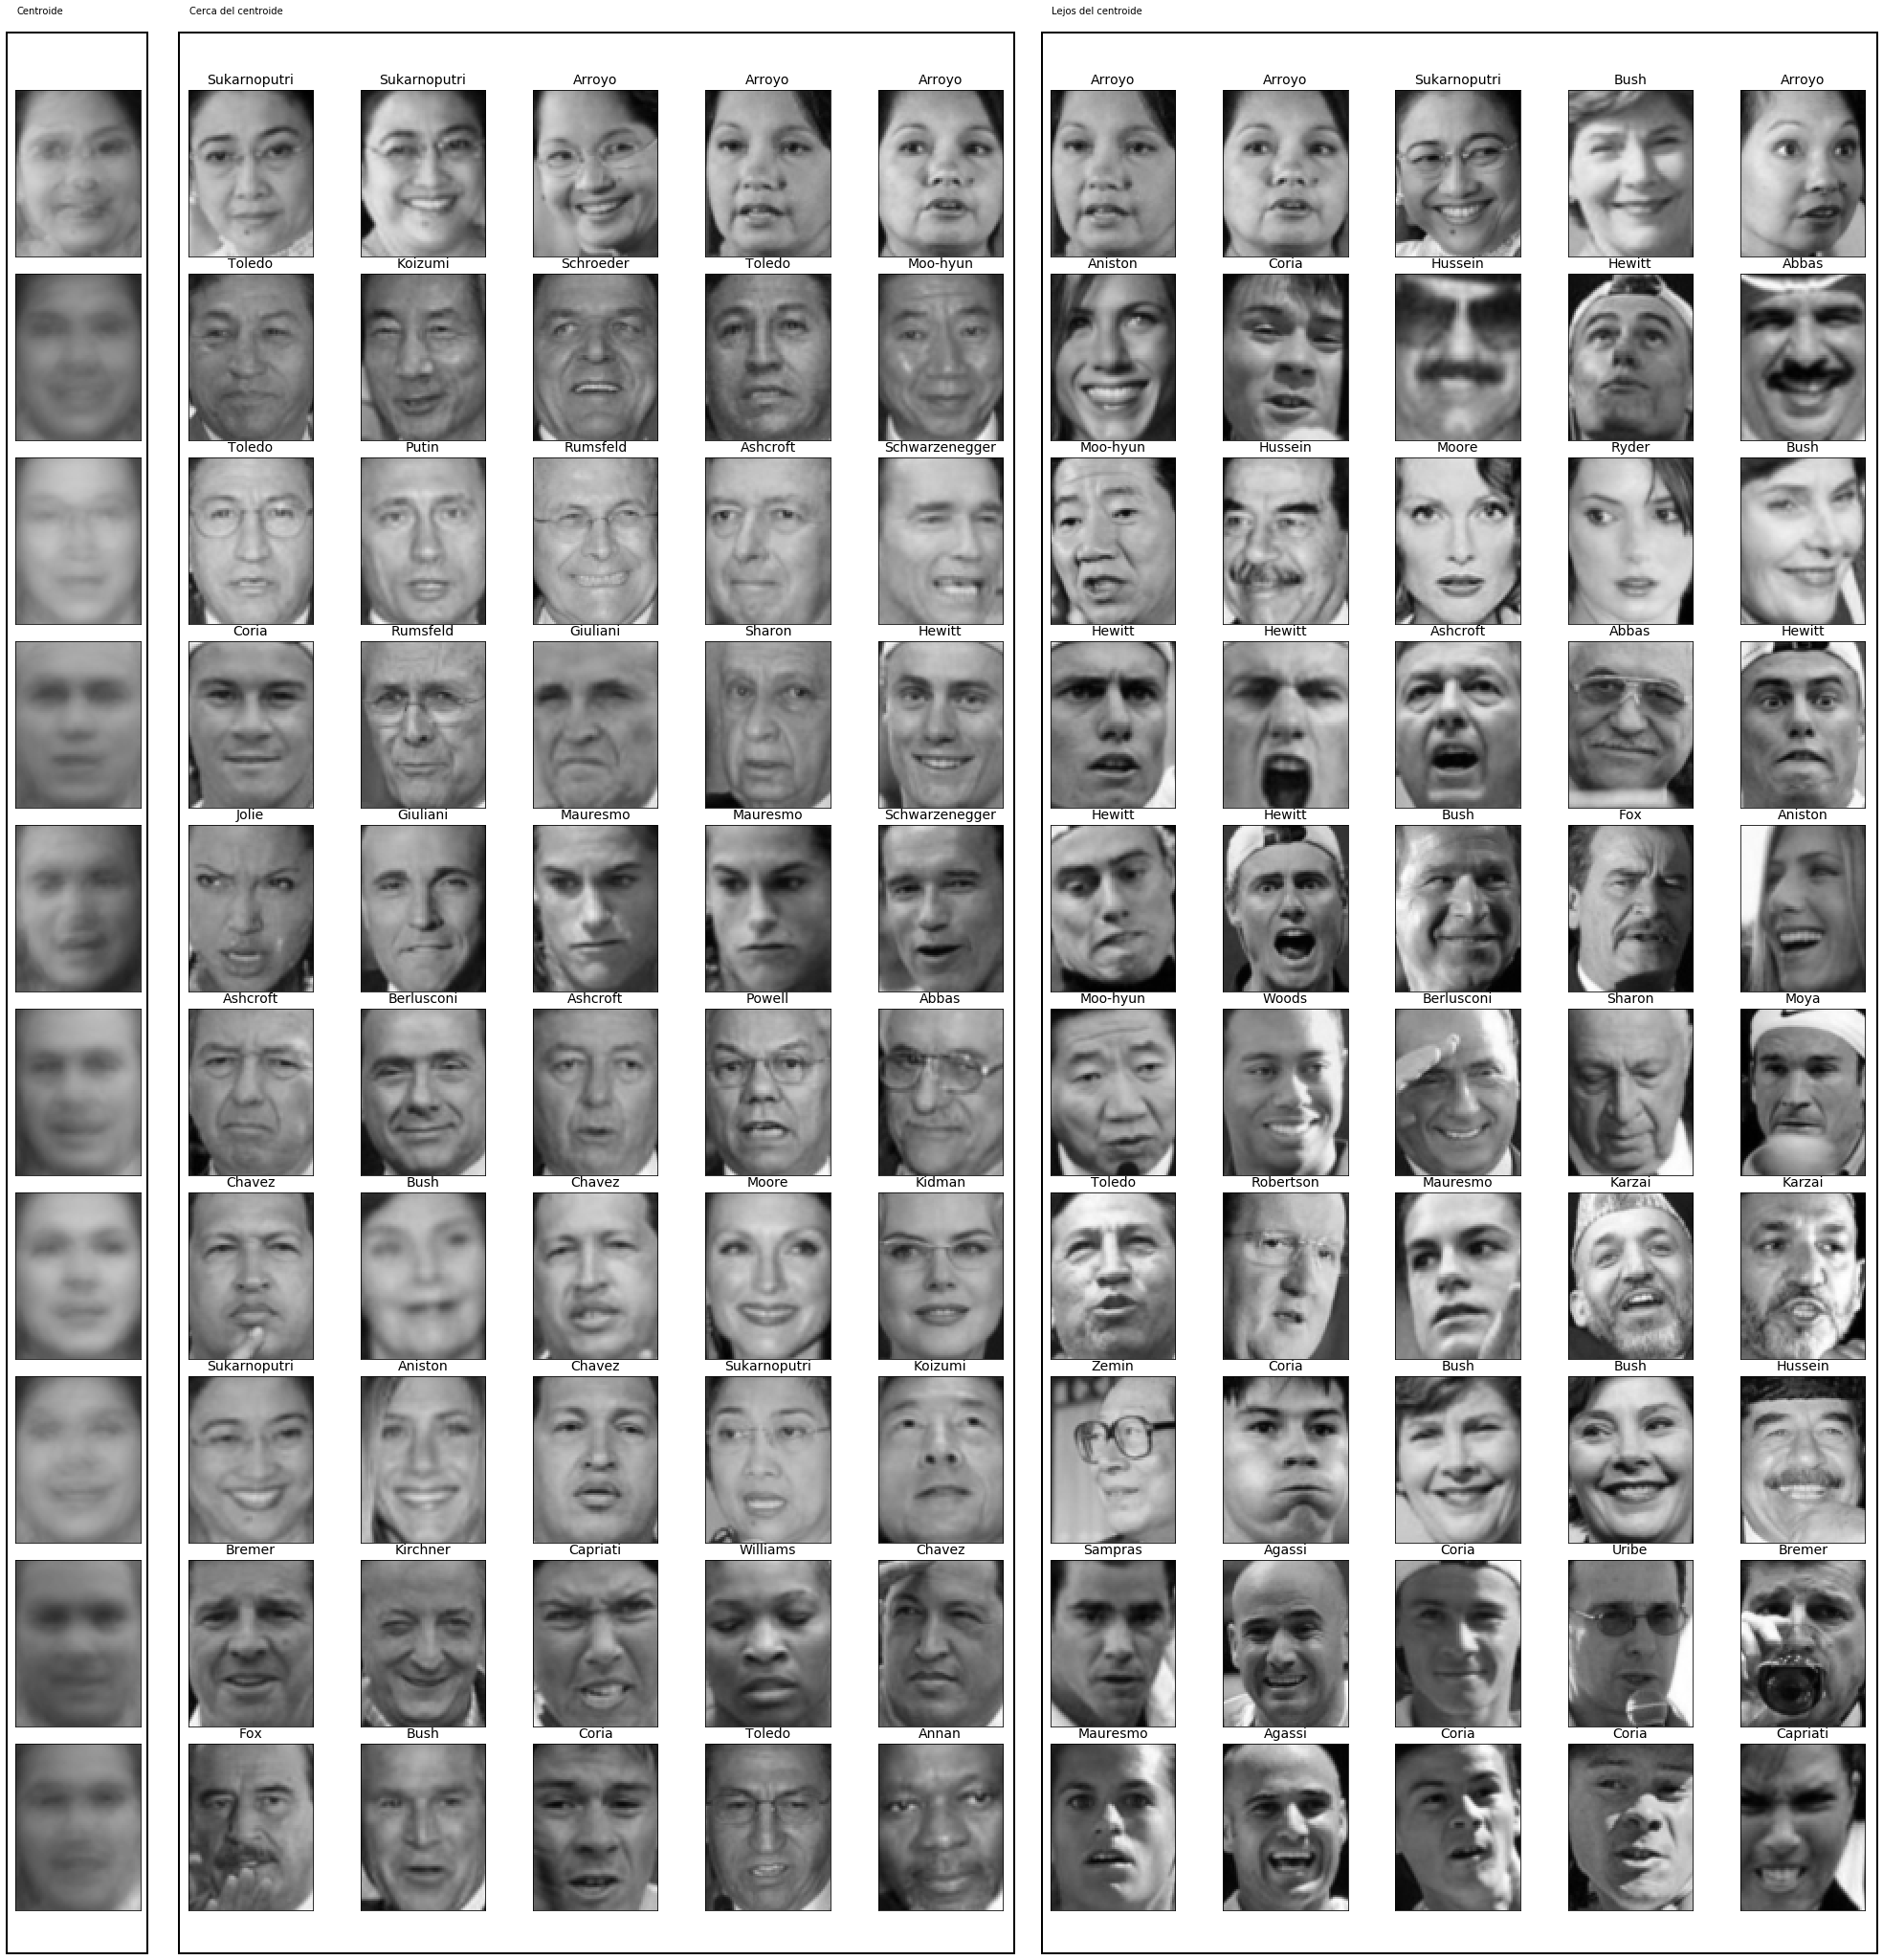

In [9]:
#mostrar sólo 10 grupos....(no es necesario entender el código sólo mirar el resultado!)
n_clusters = 10
image_shape = (87, 65)

fig, axes = plt.subplots(n_clusters, 11, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(35, 35), gridspec_kw={"hspace": .1})

for cluster in range(n_clusters):
    center = km60.cluster_centers_[cluster]
    mask = km60.labels_ == cluster
    dists = np.sum((X_people - center) ** 2, axis=1)
    dists[~mask] = np.inf
    inds = np.argsort(dists)[:5]
    dists[~mask] = -np.inf
    inds = np.r_[inds, np.argsort(dists)[-5:]]
    axes[cluster, 0].imshow(center.reshape(image_shape), vmin=0, vmax=1)
    for image, label, asdf, ax in zip(X_people[inds], y_people[inds],
                                      km60.labels_[inds], axes[cluster, 1:]):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title("%s" % (people.target_names[label].split()[-1]), fontdict={'fontsize': 14})

# rectángulos para separar similitudes y dis-similitudes
rec = plt.Rectangle([-5, -30], 73, 1000, fill=False, lw=2)
rec = axes[0, 0].add_patch(rec)
rec.set_clip_on(False)
axes[0, 0].text(0, -40, "Centroide")

rec = plt.Rectangle([-5, -30], 435, 1000, fill=False, lw=2)
rec = axes[0, 1].add_patch(rec)
rec.set_clip_on(False)
axes[0, 1].text(0, -40, "Cerca del centroide")

rec = plt.Rectangle([-5, -30], 435, 1000, fill=False, lw=2)
rec = axes[0, 6].add_patch(rec)
rec.set_clip_on(False)
axes[0, 6].text(0, -40, "Lejos del centroide")

$Ejercicio$: repita el ejercicio anterior al menos 2 veces utilizando diferente número de clusters y trate de deducir algunas conclusiones comparando todos los resultados de forma visual.

$Ejercicio$: repita los ejercicios pero ahora no considerando todas las características sino que utilice la técnica de reducción de dimensionalidad PCA explicada en el material complementario del primer encuentro. Compare los resultados obtenidos con y sin reducción de dimensiones enumerando algunas conclusiones.

### Clustering de caras con DBSCAN
A continuación se replicará el análisis de grupos del dataset de las caras de personajes famosos pero ahora considerando el algoritmo de agrupamiento DBSCAN. Como se estudió en la teoría, DBSCAN puede funcionar mucho mejor que el tradicional K-means bajo ciertas características de los datos. Veamos entonces qué sucede para el dataset de las caras.

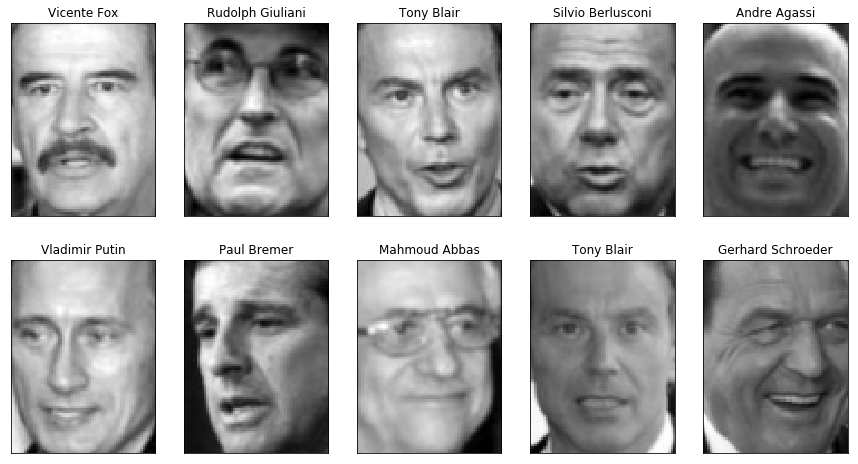

In [10]:
######descargar algunas imágenes
#por defecto las guarda en C:\Users\Leticia\scikit_learn_data\lfw_home
people = fetch_lfw_people(min_faces_per_person=19, resize=0.7)

image_shape = people.images[0].shape

#ver algunas imágenes
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])


In [11]:
#########estadísticas
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}\n".format(len(people.target_names)))

# contar
counts = np.bincount(people.target)
# imprimir
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

people.images.shape: (3156, 87, 65)
Number of classes: 69

Abdullah Gul               19   Alejandro Toledo           39   Alvaro Uribe               35   
Amelie Mauresmo            21   Andre Agassi               36   Angelina Jolie             20   
Ariel Sharon               77   Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   
Bill Clinton               29   Carlos Menem               21   Carlos Moya                19   
Colin Powell              236   David Beckham              31   Donald Rumsfeld           121   
George Robertson           22   George W Bush             530   Gerhard Schroeder         109   
Gloria Macapagal Arroyo    44   Gray Davis                 26   Guillermo Coria            30   
Hamid Karzai               22   Hans Blix                  39   Hugo Chavez                71   
Igor Ivanov                20   Jack Straw                 28   Jacques Chirac             52   
Jean Chretien              55   Jennifer Aniston           21   Jenn

In [12]:
#construcción del modelo de clustering con DBSCAN (parámetros por defecto)
dbscan = DBSCAN()
labels_dbs = dbscan.fit_predict(people.data)
print("Etiquetas únicas: {}",format(np.unique(labels_dbs)))

Etiquetas únicas: {} [-1]


Como se puede notar, DBSCAN no pudo agrupar correctamente las caras en grupos, no identifica suficiente densidad en los datos como para poder armar grupos y por ende considera que todos los datos como ruido. 

Para revertir esta situación se puede utilizar otros parámetros mas que los por defecto. Por ejemplo fijando el número mínimo de muestras consideradas en el vecindario de un punto a un valor más bajo (por defecto es 5) y aumentando el valor máximo de la distancia entre dos puntos para ser considerados como pertenecientes al mismo vecindario (eps por defecto es 0.5).

In [13]:
#construcción del modelo de clustering con DBSCAN 
dbscan = DBSCAN(min_samples=3, eps=18)
labels_dbs = dbscan.fit_predict(people.data)
print("Etiquetas únicas: {}",format(np.unique(labels_dbs)))

#for eps in [0.1, 0.3, 0.55, 0.77, 0.9, 1, 10, 30, 40, 60]:
#    print("\neps={}".format(eps))
#    dbscan = DBSCAN(eps=eps, min_samples=2)
#    labels = dbscan.fit_predict(people.data)
#    print("Num de clusters: {}".format(len(np.unique(labels))))
#    print("Cluster de tam: {}".format(np.bincount(labels + 1)))
    

Etiquetas únicas: {} [-1]


Como podemos observar no es posible detectar grupos en esta versión del dataset ya que los datos tal cual están no son lo suficientemente densos como para ser agrupados. 

Una posible solución es utilizar menos atributos en la representación de los datos de manera de reducir la dimensionalidad del espacio. Para ello utilizaremos la representación "eigenface" de los datos con 100 componentes. 

In [14]:
# extracción de los eigenfaces y transformación de los datos
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(people.data)
X_pca = pca.transform(people.data)


In [15]:
#construcción del modelo de clustering con DBSCAN 
dbscan = DBSCAN(min_samples=3, eps=18)
labels_dbs = dbscan.fit_predict(X_pca)
print("Etiquetas únicas: {}",format(np.unique(labels_dbs)))

Etiquetas únicas: {} [-1  0]


Observar cómo con la reducción de la dimensionalidad de los datos y una representación más informativa que sólo los pixels crudos, es posible determinar al menos un grupo (y outliers).

Podemos estudiar cuántos puntos son efectivamente ruido (representados con -1) y cuántos están agrupados (grupo 0).

In [16]:
#bincount no permite números negativos entonces sumamos 1
print("Puntos por clusters: {}",format(np.bincount(labels_dbs + 1)))

Puntos por clusters: {} [   4 3152]


Sólo 4 datos fueron etiquetados como ruido. Veamos cuáles son.

[[ 61.333  62.333  61.667 ...  95.333 108.667 112.   ]
 [221.667 214.    207.667 ... 175.    139.    104.667]
 [  4.333   4.      4.    ...  66.333  64.333  64.333]
 [ 53.333  55.333  57.    ...  54.     52.667  52.   ]]


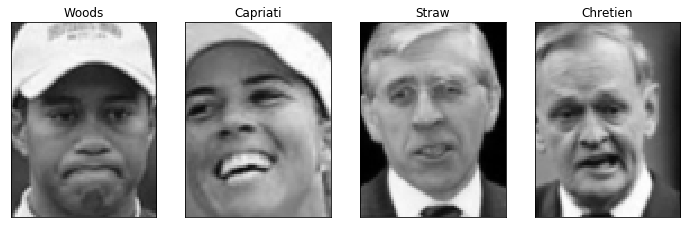

In [17]:
noise = people.data[labels_dbs==-1]

print(noise)

fig, axes = plt.subplots(1, 4, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for image, ax, label in zip(noise/255, axes.ravel(), people.target[labels_dbs==-1]):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
    ax.set_title(people.target_names[label].split()[-1])
      
    

Si comparamos estas 4 imágenes correspondiente a "ruido" en el dataset (según DBSCAN) con respecto a las imágenes de muestra graficadas luego de cargar el dataset, se puede observar que las 2 primeras tienen una gorra, la tercera la persona tiene lentes y la cuarta no está centrada correctamente (al igual que la segunda). Estas características podrían ser las que el algoritmo de clustering considera importantes como para calificar a las imágenes como outliers

Este análisis habitualmente se denomina "detección de outliers". Una vez detectados podríamos estar interesados en eliminar estas imágenes o simplemente centrarlas de forma de trabajar con datos más homogéneos.

Para finalizar, tratemos de encontrar grupos más interesantes variando la distancia máxima entre dos puntos para que sean considerados dentro del mismo vecindario (parámetro eps de la función de clustering) entre 0.5 y 18.


In [18]:
for eps in [0.55, 1, 4, 6, 8, 10, 13, 15, 17]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels_dbs = dbscan.fit_predict(X_pca)
    print("Num de clusters: {}".format(len(np.unique(labels_dbs))))
    print("Contenido de clusters: {}".format(np.unique(labels_dbs)))
    print("Cluster de tam: {}".format(np.bincount(labels_dbs + 1)))
    


eps=0.55
Num de clusters: 1
Contenido de clusters: [-1]
Cluster de tam: [3156]

eps=1
Num de clusters: 1
Contenido de clusters: [-1]
Cluster de tam: [3156]

eps=4
Num de clusters: 1
Contenido de clusters: [-1]
Cluster de tam: [3156]

eps=6
Num de clusters: 6
Contenido de clusters: [-1  0  1  2  3  4]
Cluster de tam: [3136    3    3    7    3    4]

eps=8
Num de clusters: 9
Contenido de clusters: [-1  0  1  2  3  4  5  6  7]
Cluster de tam: [2508  621    3    4    4    7    3    3    3]

eps=10
Num de clusters: 3
Contenido de clusters: [-1  0  1]
Cluster de tam: [1070 2083    3]

eps=13
Num de clusters: 2
Contenido de clusters: [-1  0]
Cluster de tam: [ 151 3005]

eps=15
Num de clusters: 2
Contenido de clusters: [-1  0]
Cluster de tam: [  38 3118]

eps=17
Num de clusters: 2
Contenido de clusters: [-1  0]
Cluster de tam: [   5 3151]


Para los 3 valores de eps más bajos, DBSCAN etiquetó los datos como ruido. Para los 3 últimos valores de eps, el algoritmo de clustering encontró un gran grupo y los demás puntos fueron vistos como ruido. Para el caso de eps=6, se obtuvieron 5 grupos y luego abundante ruido. Se puede estudiar cada uno de esos 5 grupos y ver cómo están conformados.

Contenido del clustering: [-1  0  1  2  3  4]
Cantidad de datos por grupo: [3136    3    3    7    3    4]


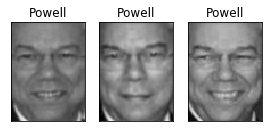

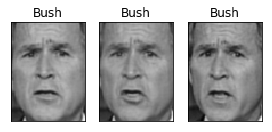

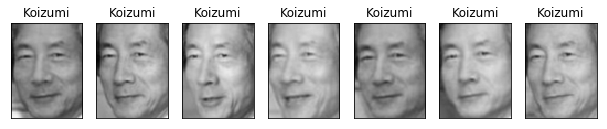

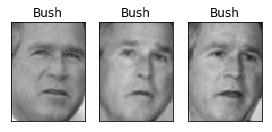

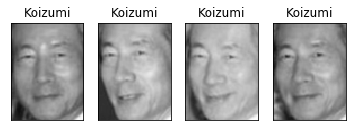

In [19]:
dbscan = DBSCAN(min_samples=3, eps=6)
labels_dbs = dbscan.fit_predict(X_pca)

print("Contenido del clustering: {}".format(np.unique(labels_dbs)))
print("Cantidad de datos por grupo: {}".format(np.bincount(labels_dbs + 1)))

for cluster in range(max(labels_dbs) + 1):
    mask = labels_dbs == cluster
    n_images =  np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
    
    for image, ax, label in zip(people.data[mask]/255, axes, people.target[mask]):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])
           
    

Contenido del clustering: [-1  0  1  2  3  4  5  6  7]
Cantidad de datos por grupo: [2508  621    3    4    4    7    3    3    3]


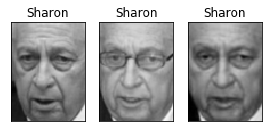

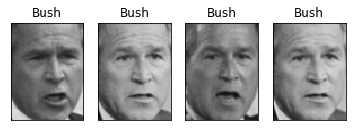

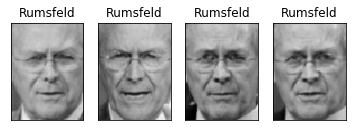

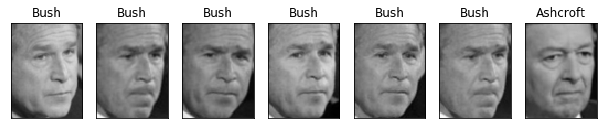

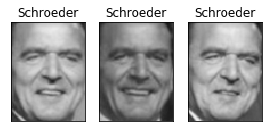

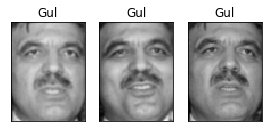

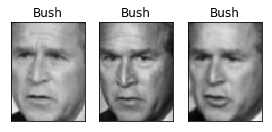

<Figure size 0x288 with 0 Axes>

In [20]:
dbscan = DBSCAN(min_samples=3, eps=8)
labels_dbs = dbscan.fit_predict(X_pca)

print("Contenido del clustering: {}".format(np.unique(labels_dbs)))
print("Cantidad de datos por grupo: {}".format(np.bincount(labels_dbs + 1)))

for cluster in range(max(labels_dbs) + 1):  
    mask = labels_dbs == cluster + 1 #obviamos el 1er grupo grande 
    n_images =  np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
    
    for image, ax, label in zip(people.data[mask]/255, axes, people.target[mask]):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

$Ejercicio$: observando los resultados de los dos clustering con DBSCAN (eps=6 y eps=8) enumere algunas conclusiones interesantes.

$Ejercicio$: varíe nuevamente los valores de eps y compare resultados. 

## Evaluación de los clusterings

### MVI: Coeficiente de Silueta
A continuación vamos a evaluar los agrupamientos obtenidos con la medida de validez interna `coeficiente de silueta`. Recordar que no es necesario conocer el ground-truth del agrupamiento para poder aplicar esta métrica.

Comencemos con la definición de una función que nos será de utilidad para graficar los coeficientes de silueta de cada dato, luego de cada grupo y finalmente veremos el del agrupamiento. 

In [21]:
def silCoef_clustering(clust,  X, param1=5, param2=0.5, metric = 'euclidean'):
    # basada en la definición de 'silh_samp_cluster' del libro "Python Machine Learning" (Sebastian Raschkas)
    if clust==KMeans:
        print("-----Agrupamiento kMeans-----")
        km = clust(n_clusters = param1)
    if clust==DBSCAN:
        print("-----Agrupamiento DBSCAN-----")
        km = DBSCAN(min_samples=param1, eps=param2)
    
               
    y_km = km.fit_predict(X)
    cluster_labels = np.unique(y_km)
    
    n_clusters = cluster_labels.shape[0]
    #calcular la silueta para cada dato
    silhouette_vals = silhouette_samples(X, y_km, metric = metric)
    y_ax_lower, y_ax_upper =0,0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        #silueta del grupo
        print("La Silueta para el grupo " + str(c+1) + " es: " + str(np.mean(c_silhouette_vals)))
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color = color)
        yticks.append((y_ax_lower + y_ax_upper)/2.)
        y_ax_lower+= len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    #silueta del agrupamiento
    print("Silueta para el agrupamiento: " + str(silhouette_avg))
    plt.axvline(silhouette_avg,
        color = 'red',
        linestyle = "--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel("Grupo")
    plt.xlabel("Coeficiente de Silueta")
    plt.title('Silueta para k = ' + str(param1) + " grupos")
    plt.show()
    


In [22]:
#Carga de datos (nuevamente)
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

#calculo las nuevas estadísticas
print("Cantidad de caras: {}".format(people.images[mask].shape))
print("Correspondiente a personas: ", np.bincount(y_people).size)

# contar
counts=np.bincount(y_people)
# imprimir
#for i, (count, name) in enumerate(zip(counts, people.target_names)):
#    print("{0:25} {1:3}".format(name, count), end='   ')
#    if (i + 1) % 3 == 0:
#        print()


# construcción del modelo de clustering
km = KMeans(n_clusters=2)
labels_km = km.fit_predict(X_people)
print("Tamaño de los grupos obtenidos con k-means para 2 grupos: {}".format(np.bincount(labels_km)))

#Silueta para k-means 
print("Silhouette-Score (promedio) para ", 2,  "Clusters: ", silhouette_score(X_people, labels_km))

Cantidad de caras: (2196, 87, 65)
Correspondiente a personas:  69
Tamaño de los grupos obtenidos con k-means para 2 grupos: [1268  928]
Silhouette-Score (promedio) para  2 Clusters:  0.12698033


-----Agrupamiento kMeans-----
La Silueta para el grupo 1 es: 0.1364731
La Silueta para el grupo 2 es: 0.11400961
Silueta para el agrupamiento: 0.12698033


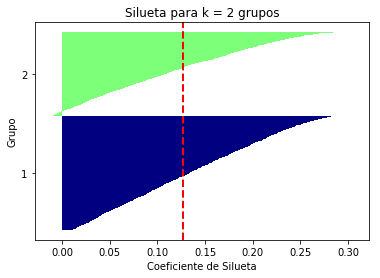

In [23]:
#gráfica de la silueta de cada grupo
silCoef_clustering(KMeans, X_people, param1=2)

In [24]:
#construcción del modelo de clustering con DBSCAN 
dbscan = DBSCAN(min_samples=3, eps=10)
labels_dbs = dbscan.fit_predict(X_pca)
print("Etiquetas únicas: {}",format(np.unique(labels_dbs)))
print("Cluster de tam: {}",format(np.bincount(labels_dbs + 1)))

lbs_unique = np.unique(labels_dbs)

#print(lbs_unique)

# Num de grupos sin considerar el ruido
n_grupos = len(set(lbs_unique)) - (1 if -1 in labels_dbs else 0)
#print("Grupos para el coeficiente de silueta: ", n_grupos)

#Silueta para dbscan 
print("Silhouette-Score para dbscan con ruido 3 Clusters: ", silhouette_score(X_pca, labels_dbs))


#filtrar ruido
X_pca_filter = X_pca[labels_dbs > -1]
labels_dbs_filter = [i for i in labels_dbs if i > -1]

print("Etiquetas únicas: {}",format(np.unique(labels_dbs_filter)))
print("Cluster de tam: {}",format(np.bincount(labels_dbs_filter)))

#Silueta para dbscan sin ruido
print("Silhouette-Score (sin ruido) para 2 Clusters: ", silhouette_score(X_pca_filter, labels_dbs_filter))

Etiquetas únicas: {} [-1  0  1]
Cluster de tam: {} [1070 2083    3]
Silhouette-Score para dbscan con ruido 3 Clusters:  0.01890572
Etiquetas únicas: {} [0 1]
Cluster de tam: {} [2083    3]
Silhouette-Score (sin ruido) para 2 Clusters:  0.09382663


-----Agrupamiento DBSCAN-----
La Silueta para el grupo 0 es: -0.12712522
La Silueta para el grupo 1 es: 0.0936015
La Silueta para el grupo 2 es: 0.23950619
Silueta para el agrupamiento: 0.01890572


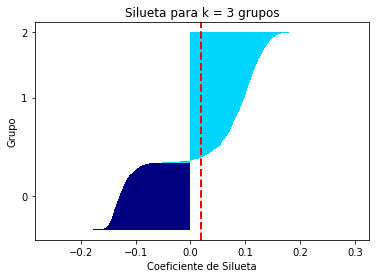

In [25]:
#gráfica de la silueta de cada grupo dbscan con ruido
silCoef_clustering(DBSCAN, X_pca, param1=3, param2=10)



-----Agrupamiento kMeans-----
La Silueta para el grupo 1 es: 0.055419378
La Silueta para el grupo 2 es: 0.0741404
La Silueta para el grupo 3 es: 0.040869407
La Silueta para el grupo 4 es: 0.0841183
La Silueta para el grupo 5 es: 0.07083014
Silueta para el agrupamiento: 0.06498382


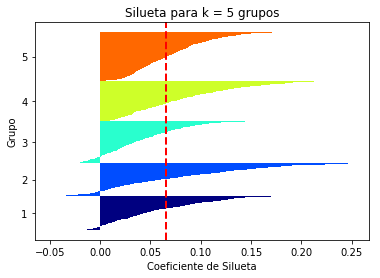

-----Agrupamiento DBSCAN-----
La Silueta para el grupo 0 es: -0.16502446
La Silueta para el grupo 1 es: 0.3567315
La Silueta para el grupo 2 es: 0.5337476
La Silueta para el grupo 3 es: 0.18832883
La Silueta para el grupo 4 es: 0.45351288
La Silueta para el grupo 5 es: 0.21983978
Silueta para el agrupamiento: -0.16200477


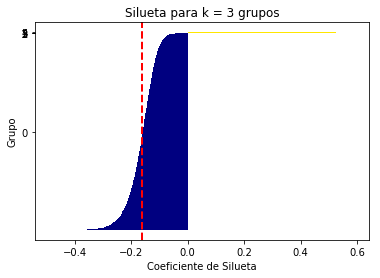

In [26]:
#k-means
silCoef_clustering(KMeans, X_people, param1=5)

#dbscan
silCoef_clustering(DBSCAN, X_pca, param1=3, param2=6)

$Ejercicio$: extraiga conclusiones en base a los coeficientes de silueta de los agrupamientos obtenidos. 

